# Tutorial for Multiclass Training

At this tutorial, we will train the ResNet on the esc50 data which is a mutlticlass dataset and evaluate our model by the whole test data. 

# Step1) Import esc50 Dataset



In [1]:
from birdset.datamodule.components.event_decoding import EventDecoding
from birdset.datamodule.components.transforms import  BirdSetTransformsWrapper
from birdset.datamodule.base_datamodule import DatasetConfig
from birdset.datamodule.esc50_datamodule import ESC50DataModule


transforms = BirdSetTransformsWrapper(model_type='vision', decoding=EventDecoding(sampling_rate=32000), task="multiclass")
#, preprocessing=PreprocessingConfig(spectrogram_conversion=Spectrogram(n_fft=1024, hop_length=79),melscale_conversion=MelScale ( n_mels=128)))
dataset_config = DatasetConfig(
    data_dir="../../data_birdset",
    dataset_name="esc50",
    hf_path="ashraq/esc50",
    hf_name="default",
    seed=2,
    n_classes=50,
    n_workers=1,
    val_split=0.2,
    task="multiclass",
    subset=None,
    sampling_rate=32000,
)
dm = ESC50DataModule(dataset=dataset_config, transforms=transforms)

/home/vscode/.cache/pypoetry/virtualenvs/birdset-xS3fZVNL-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vscode/.cache/pypoetry/virtualenvs/birdset-xS3fZVNL-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# Step2) Prepare Data

In [ ]:
dm.prepare_data()
print(dm.len_trainset)
print(dm.num_classes)
dm.setup(stage='fit')
train_dataloader = dm.train_dataloader
test_loader = dm.test_dataloader()

# Read and plot Spectrogram of one sample of data

dict_keys(['input_values', 'labels'])
torch.Size([32, 1, 128, 1024])
torch.Size([32])


{'input_values': tensor([[[[ 5.8352e+00,  5.8352e+00,  5.8352e+00,  ...,  1.6575e+01,
             1.6575e+01,  1.6575e+01],
           [ 5.8352e+00,  5.8352e+00,  5.8352e+00,  ...,  1.6575e+01,
             1.6575e+01,  1.6575e+01],
           [ 5.8352e+00,  5.8352e+00,  5.8352e+00,  ...,  1.6575e+01,
             1.6575e+01,  1.6575e+01],
           ...,
           [ 5.8352e+00,  5.8352e+00,  5.8352e+00,  ...,  1.6575e+01,
             1.6575e+01,  1.6575e+01],
           [ 5.8352e+00,  5.8352e+00,  5.8352e+00,  ...,  1.6575e+01,
             1.6575e+01,  1.6575e+01],
           [ 5.8352e+00,  5.8352e+00,  5.8352e+00,  ...,  1.6575e+01,
             1.6575e+01,  1.6575e+01]]],
 
 
         [[[ 5.8352e+00,  5.8352e+00,  5.8352e+00,  ...,  1.6575e+01,
             1.6575e+01,  1.6575e+01],
           [ 4.9323e+00,  5.8352e+00,  5.8352e+00,  ...,  1.6575e+01,
             1.6575e+01,  1.6575e+01],
           [ 4.5614e+00,  3.7705e+00,  4.1276e+00,  ...,  1.6575e+01,
             1.6575e

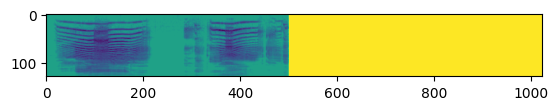

In [4]:
from matplotlib import pyplot as plt

# get first batch
batch = next(iter(train_dataloader()))
print(batch.keys())
print(batch['input_values'].shape)
print(batch['labels'].shape)

spectorgram = batch['input_values'][0]

plt.imshow(spectorgram.squeeze().numpy())
batch

# Step3) Prepare trainer

In this tutorial we train our model with 20 epochs to show how it works and make a visible pipline . For having reasonable results the model should be traind by more epochs. 

In [8]:
#from train_loader = dm.train_dataloader() import Trainer
from lightning import Trainer
min_epochs = 1
max_epochs = 20
trainer = Trainer(min_epochs=min_epochs, max_epochs=max_epochs, accelerator="gpu", devices=[0])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


# Step4) Prepare your model

In [16]:
from birdset.modules.metrics.multiclass import MulticlassMetricsConfig
from birdset.modules.models.resnet import ResNetClassifier
from birdset.modules.base_module import BaseModule,NetworkConfig
from torch.nn import CrossEntropyLoss

NetworkConfig=NetworkConfig(        
        model=ResNetClassifier(baseline_architecture="resnet50",num_classes =50,num_channels=1),
        model_name ="resnet50",
        model_type="vision",
        torch_compile= False,
        sample_rate=32000,
        normalize_waveform=False,
        normalize_spectrogram=True)


model = BaseModule(
    network=NetworkConfig,
    loss=CrossEntropyLoss(),
    #label_counts= 50,
    len_trainset=dm.len_trainset,
    task=dm.task,
    batch_size=dm.train_batch_size,
    num_epochs=max_epochs,
    metrics=MulticlassMetricsConfig(num_labels=50)
    )


        # define optimizer and scheduler

In [17]:
model

BaseModule(
  (loss): CrossEntropyLoss()
  (model): ResNetClassifier(
    (model): ResNet(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

# Step5) Initializing your model with esc50 data

In [18]:
trainer.fit(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                  | Type               | Params
-------------------------------------------------------------
0 | loss                  | CrossEntropyLoss   | 0     
1 | model                 | ResNetClassifier   | 23.6 M
2 | train_metric          | MulticlassAccuracy | 0     
3 | valid_metric          | MulticlassAccuracy | 0     
4 | test_metric           | MulticlassAccuracy | 0     
5 | valid_metric_best     | MaxMetric          | 0     
6 | valid_add_metrics     | MetricCollection   | 0     
7 | test_add_metrics      | MetricCollection   | 0     
8 | test_complete_metrics | MetricCollection   | 0     
-------------------------------------------------------------
23.6 M    Trainable params
0         Non-trainable params
23.6 M    Total params
94.417    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


# Step6) Evaluate your model with your test data

In [ ]:
trainer.test(model=model,dataloaders=test_loader,ckpt_path="best")